<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Генеративные модели в машинном обучении, МОВС, ФКН ВШЭ</center></h1>
<h2><center>Домашнее задание 3: Диффузия, потоки</center></h2>

# Введение

До заголовка "Диффузионные модели" все по-старому. Только Задания 1-2 теперь неоцениваемые, ведь вы их уже делали

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

    Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.

    По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

    Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

    Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import sys

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [3]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [4]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [5]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [6]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [7]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="green")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

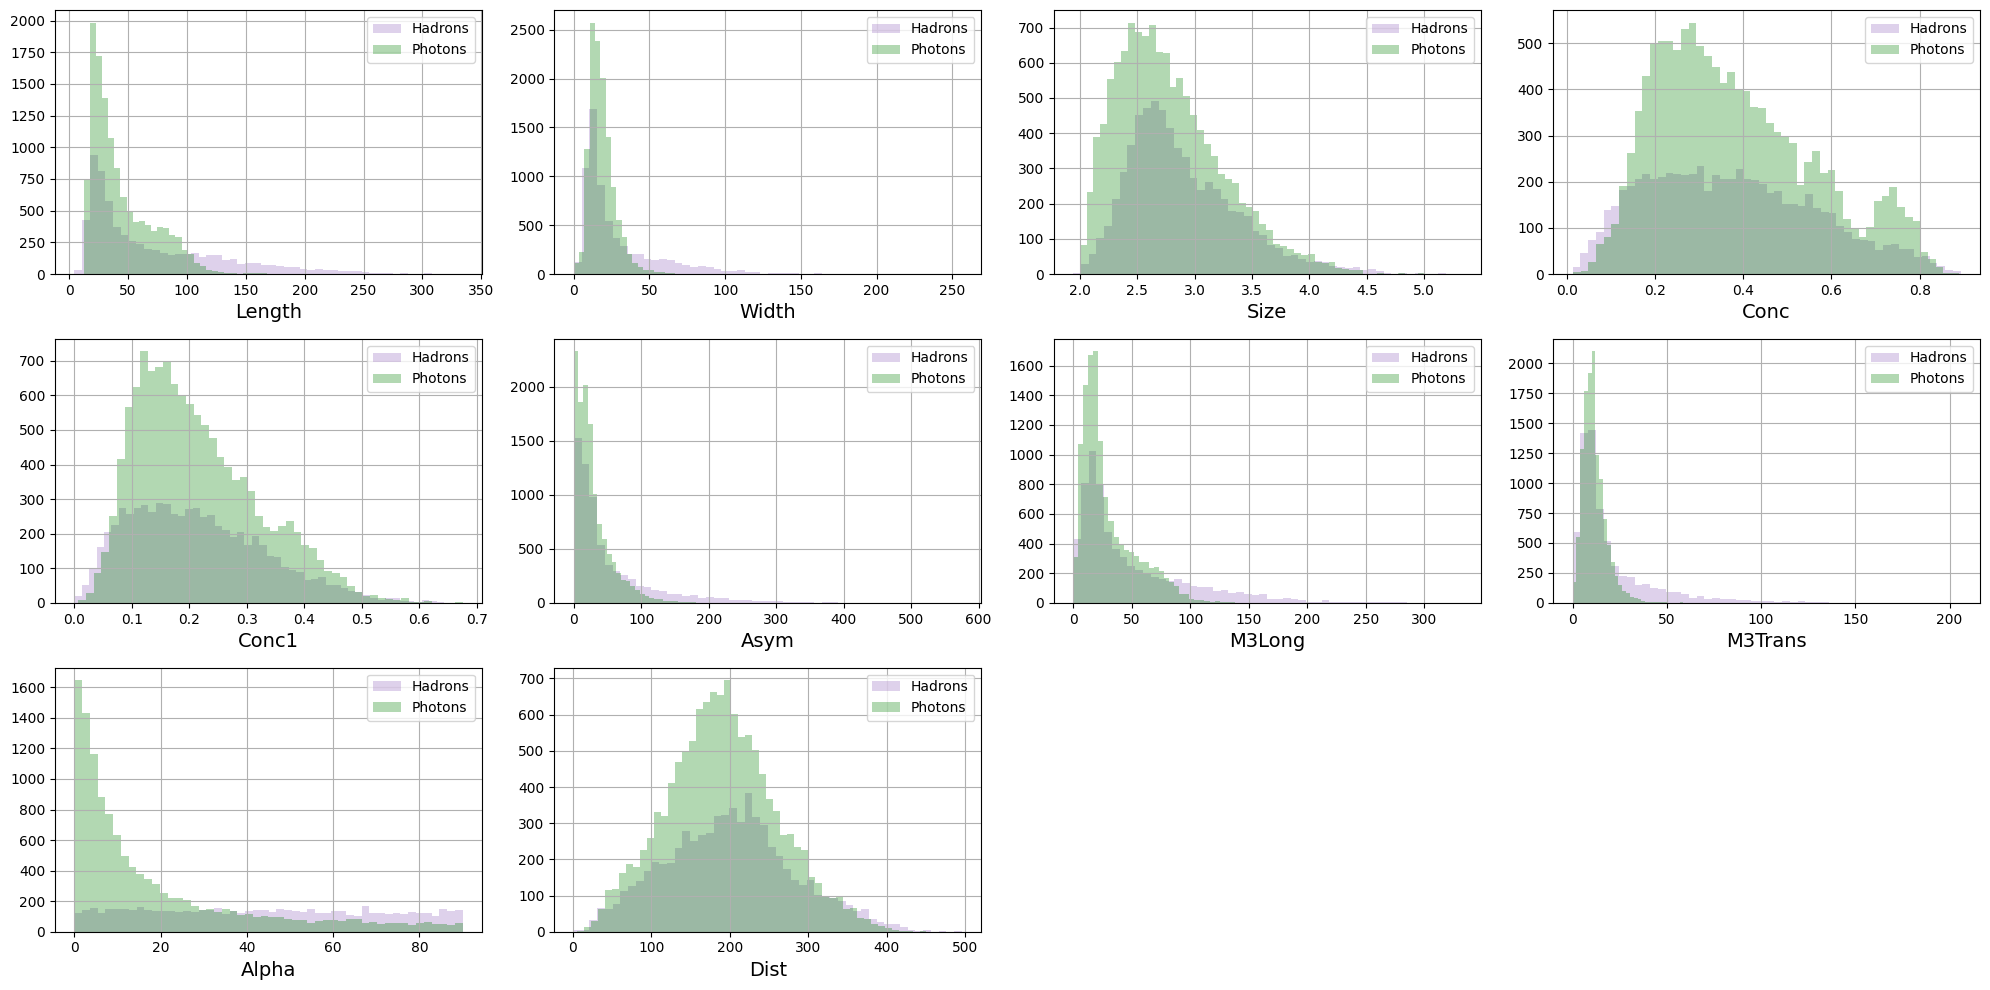

In [8]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [9]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0 баллов)

Проиллюстрируйте распределение y внутри train и test выборки.

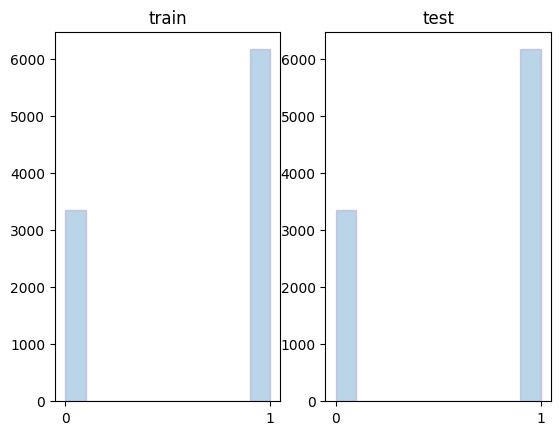

In [10]:
# your code below
ttls = ['train', 'test']
for i, sample in enumerate([y_train, y_test]):
    plt.subplot(1, 2, i+1)
    plt.hist(sample, alpha=0.3, color='C0', edgecolor='C4')
    plt.xticks([0, 1])
    plt.title(ttls[i])

## Задание 2 (0 баллов)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [10]:
### YOUR CODE IS HERE ######
from sklearn.preprocessing import QuantileTransformer

qt_train = QuantileTransformer(output_distribution='normal')
qt_test = QuantileTransformer(output_distribution='normal')
X_train = qt_train.fit_transform(X_train)
X_test = qt_test.fit_transform(X_test)
### THE END OF YOUR CODE ###

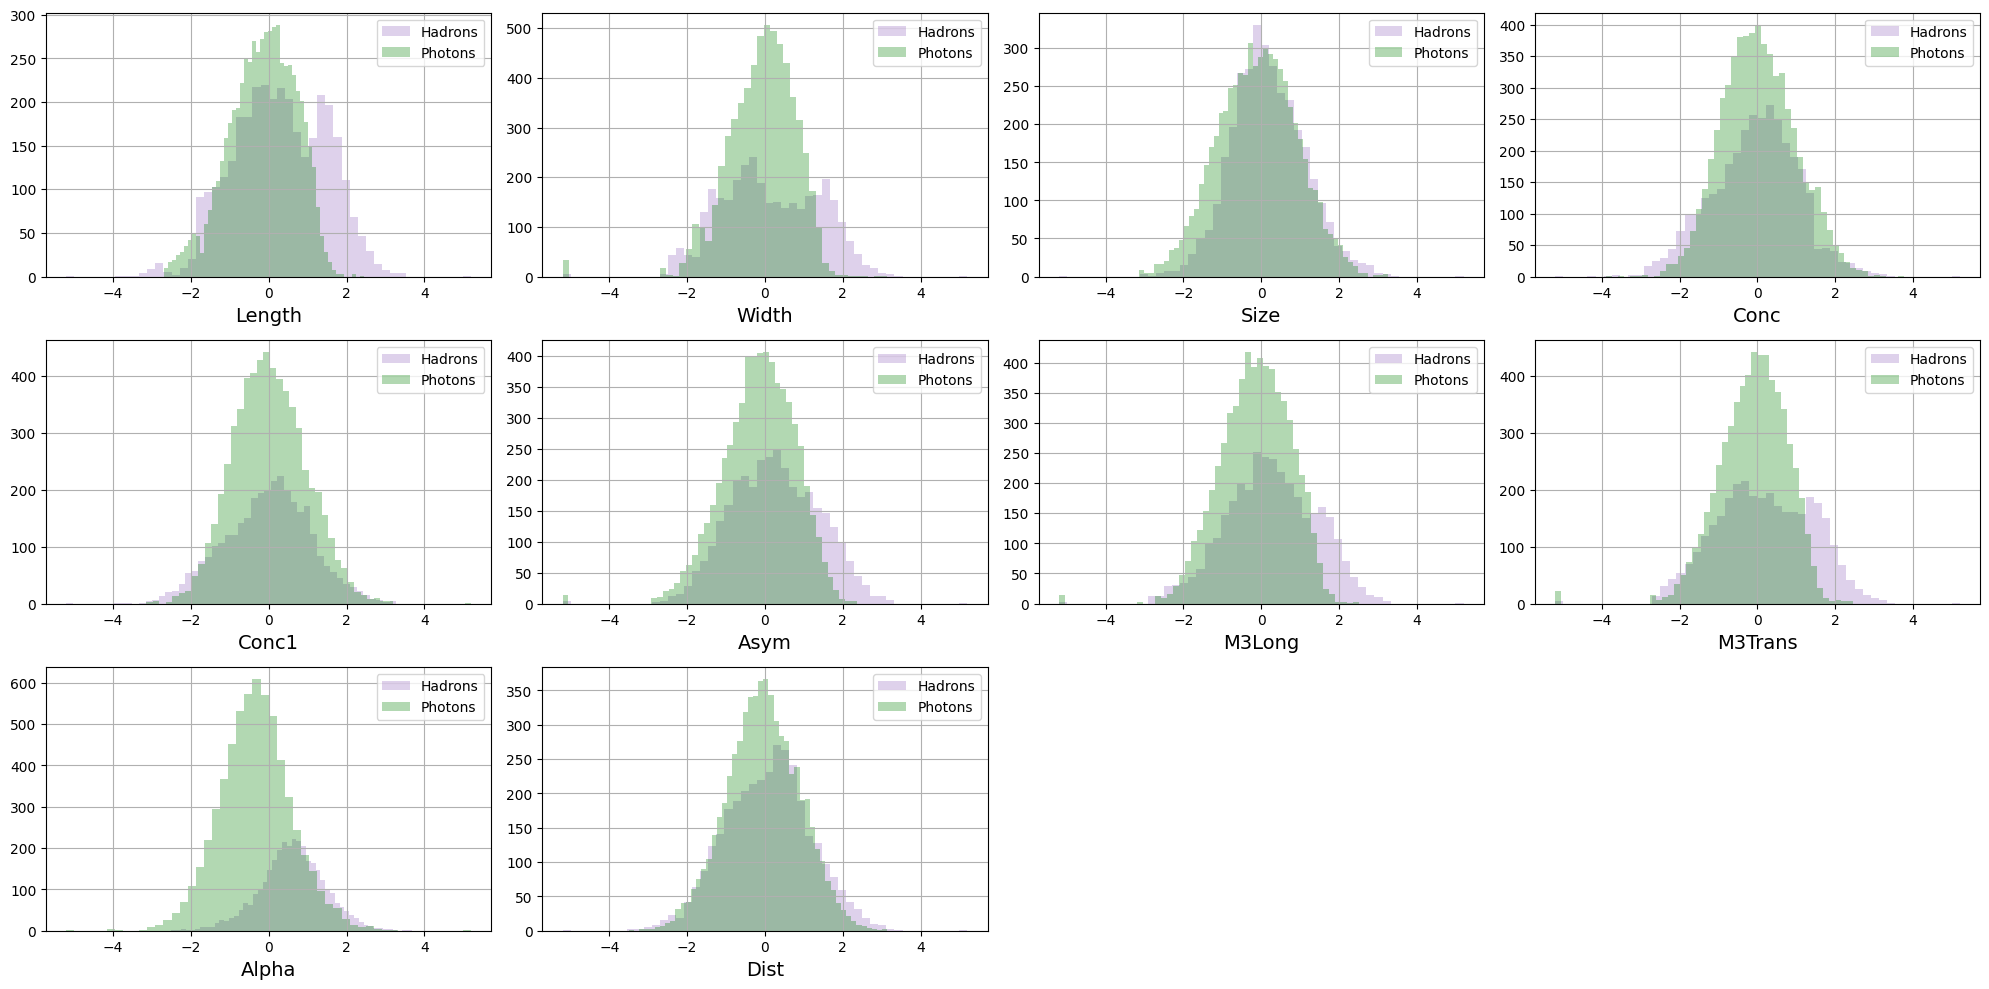

In [11]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

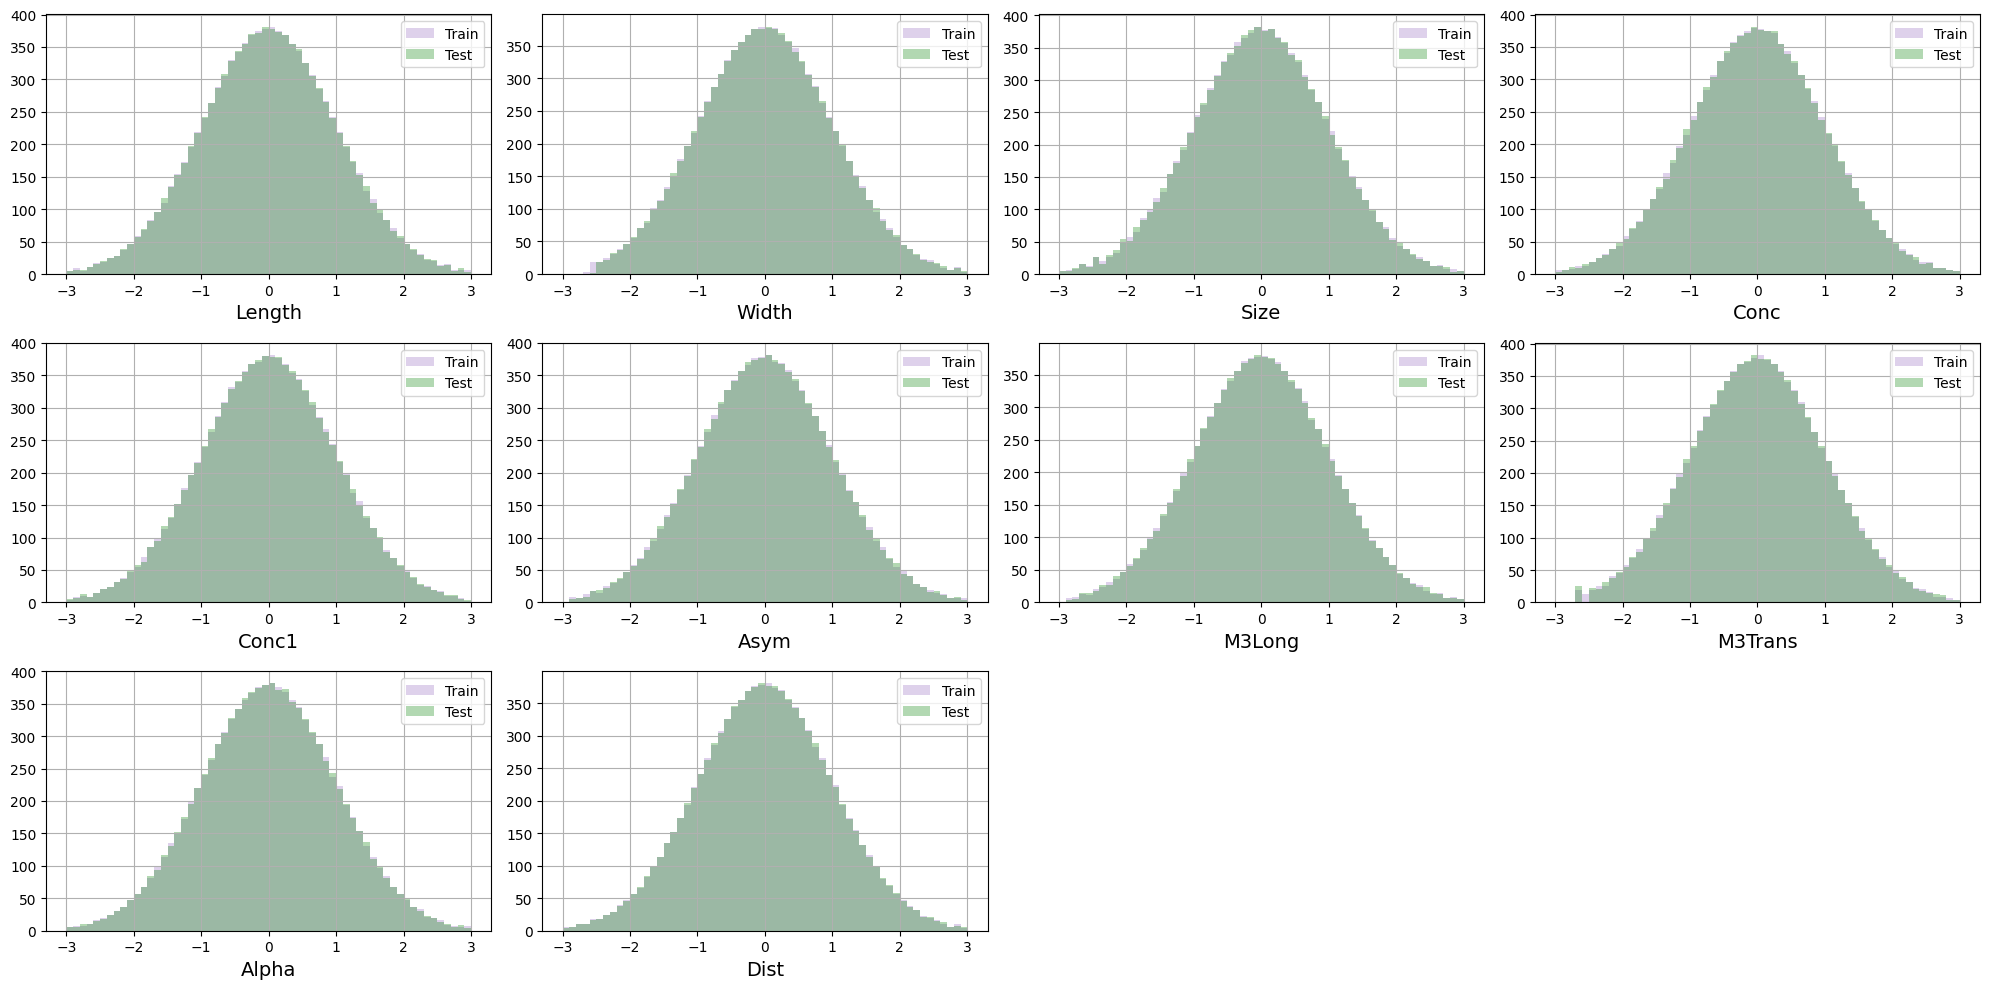

In [12]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Диффузионные модели (4 балла)

Проведем, по большому счету, такой же эксперимент, как в ДЗ-2, с диффузионной моделью.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [370]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)

## Задание 3 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

### Комментарий

Этой функцией я в итоге не пользовался и не уверен, что реализовал ее вообще правильно. Пользовался зашумлением с помощью шедулера из пакета diffusers.

In [15]:
def corrupt(x, amount):
    """
    Corrupt the input `x` by mixing it with noise according to `amount`
    :param x: torch.Tensor of shape (batch_size, num_features). In our case num_features=10
    :param amount: torch.Tensor of shape (x.shape[0], )
    """
    ### YOUR CODE IS HERE ######
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)
    ### THE END OF YOUR CODE ###
    return x * (1 - amount) + noise * amount

Добавим sсheduler, он пригодится вам при обучении модели.

*Советуем вниматиельно почитать доку по шедулеру.*

In [16]:
from diffusers import DDPMScheduler

/home/vitya/Desktop/hse_studies/gen_models/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


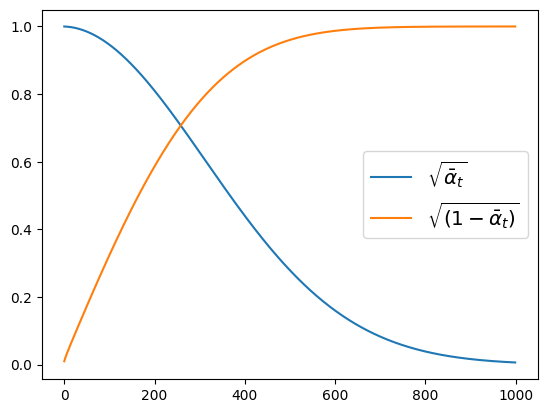

In [121]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample_range=3)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

## Задание 4 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

### Комментарий

Тут я много экспериментировал с архитектурами, и в итоге лучшее качество достиг с той, которая реализована ниже. Сам принцип, как обучать дифф. модель я реализовал по аналогии с гайдом от huggingface, вот [ссылка на коллаб](https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb#scrollTo=cAFFaVJ6tFbk).

Архитектура незамысловатая, я сделал 6 полносвязных слоев, в которых количество параметров сначала возрастает (со 100 нейронов в первом слое, до 1024 в третьем), потом симметрично убывает до размеров аутпута. Каждый слой сопровождается батч-нормализацией и функцией активации.

Вообще тут я попробовал совершенно разные варианты, пробовал использовать skip-connections, параллельно ветвил n-стаков линейных слоев и затем мерджил их аутпут в один, попытался реализовать что-то вроде U-net'a с одномерными свертками, пробовал по-разному передавать значение таймстепа и таргета в модель, но результаты были одинаково плохими. А вот с помощью этой архитектуры удалось достичь качества ~0.57 на классификации бустингом.

В итоге в модель передается шум, таймстеп и классы истинных объектов. Таймстеп предварительно скейлится в диапазон от 0 до 1, так как иначе его значение несравнимо больше, чем значение остальный признаков. Все это стакается в один тензор и прогоняется через слои. В частности, очень сильно повлял размер батча, самым лучшим оказалось значение 1600, меньше и больше вели к худшим результатам. Эпох обучения было 1000, ниже 0.2 лосс падать не хочет. Пробовал разные шедулеры, но они не помогли.

<ins>**Пожалуйста**, зачтите выбитый здесь скор в качестве предпоследнего пункта, просто чтобы не копировать все это туда!</ins>

In [310]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.net = nn.Sequential(
            # First layer
            nn.Linear(in_features=n_inputs, out_features=100),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU(),
            # Second layer
            nn.Linear(in_features=100, out_features=512),
            nn.BatchNorm1d(num_features=512),
            nn.ReLU(),
            # Third layer
            nn.Linear(in_features=512, out_features=1024),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            # Fourth layer
            nn.Linear(in_features=1024, out_features=512),
            nn.BatchNorm1d(num_features=512),
            nn.ReLU(),
            # Fifth layer
            nn.Linear(in_features=512, out_features=100),
            nn.BatchNorm1d(num_features=100),
            nn.ReLU(),
            # Final layer
            nn.Linear(in_features=100, out_features=n_outputs)
        )
        ### THE END OF YOUR CODE ###

    def forward(self, z, y, t):
        # t can be tensor (while training) or float (while inference)
        # we want to stack it upon noise data
        if torch.is_tensor(t):
            t = t.view(-1, 1)
        elif isinstance(t, float):
            t = torch.full((z.size(0), 1), t, device=DEVICE)

        zyt = torch.cat((z, y, t), dim=1)
        return self.net(zyt)

## Задание 5 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [311]:
def generate_with_diffusion(model, y, size, noise_scheduler):
    ### YOUR CODE IS HERE ######
    # Generate random noise, as well as while training
    sample = torch.randn(size).to(DEVICE)
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)

    for i, t in enumerate(noise_scheduler.timesteps):
        # Get model pred
        with torch.no_grad():
            # here we devide timestep so it's value will be in range 0 to 1
            residual = model(sample, y, t.item() / noise_scheduler.config.num_train_timesteps)

        # Update sample with step
        sample = noise_scheduler.step(residual, t, sample).prev_sample
    ### THE END OF YOUR CODE ###
    return sample

## Задание 6 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [378]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        noise_scheduler,
        batch_size = 32,
        n_epochs = 10,
        lr = 0.0001,
    ):

        self.model = model
        self.noise_scheduler = noise_scheduler
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.lr = lr

        # Using AdamW as optimizer, MSE as a loss function
        self.opt_gen = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        self.loss = torch.nn.MSELoss()
        # I tried to use scheduler but it didnt affect the results
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.opt_gen, step_size=200, gamma=0.1)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # dist params
        mu = X_real.mean(dim=0)
        std = X_real.std(dim=0)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit
        for epoch in tqdm(range(self.n_epochs), file=sys.stdout):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                # Sample noise to add to the images
                noise = torch.randn(real_batch.shape).to(DEVICE)
                bs = real_batch.shape[0]
        
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0, self.noise_scheduler.config.num_train_timesteps, (bs, ), device=DEVICE
                ).long()
        
                # Add noise to the clean images according to the noise magnitude at each timestep
                noisy_batch = self.noise_scheduler.add_noise(real_batch, noise, timesteps)
        
                # Get the model prediction
                # here we devide timestep so it's value will be in range 0 to 1
                noise_pred = model(noisy_batch, cond_batch, timesteps / self.noise_scheduler.config.num_train_timesteps)
        
                # Calculate the loss
                loss = self.loss(noise_pred, noise)
                loss.backward()
        
                # Update the model parameters with the optimizer
                self.opt_gen.step()
                self.opt_gen.zero_grad()

                loss_epoch += loss.item()

                ### THE END OF YOUR CODE ###
            # self.scheduler.step()

            # caiculate and store loss after an epoch
            loss_epoch /= len(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True))
            self.loss_history.append(loss_epoch)

        # Turn off training
        self.model.train(False)

In [359]:
%%time
model = DiffusionGenerator(n_inputs=X_train.shape[1]+2, n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    noise_scheduler=noise_scheduler,
    batch_size=1600,
    n_epochs=1000,
    lr=1e-4,
)
diffusionFitter.fit(X_train, y_train)

100%|███████████████████████████████████████| 1000/1000 [01:09<00:00, 14.46it/s]
CPU times: user 1min 9s, sys: 157 ms, total: 1min 9s
Wall time: 1min 9s


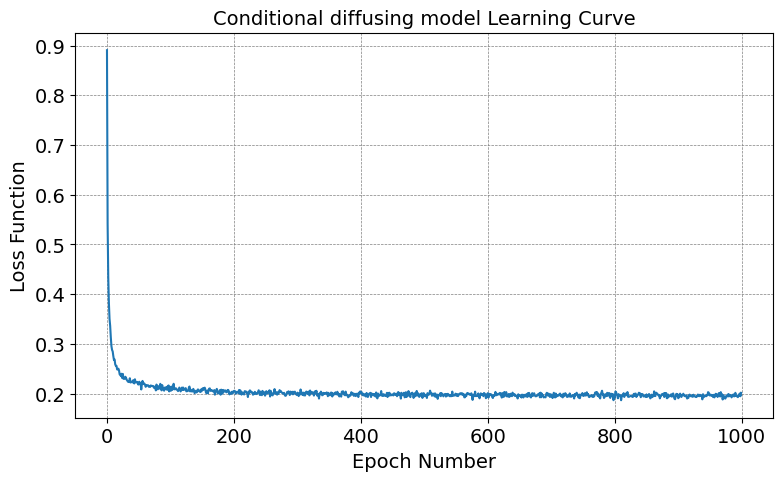

In [360]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(visible=True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 7 (0.5 балла)
По аналогии с прошлым экспериментом (из ДЗ-2) с GAN моделью сгенерируйте выборку фейковых объектов, равную размеру тестовой выборки, и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с сWGAN моделью?

In [361]:
X_fake_train = generate_with_diffusion(model, y_train, X_train.shape, noise_scheduler).cpu()

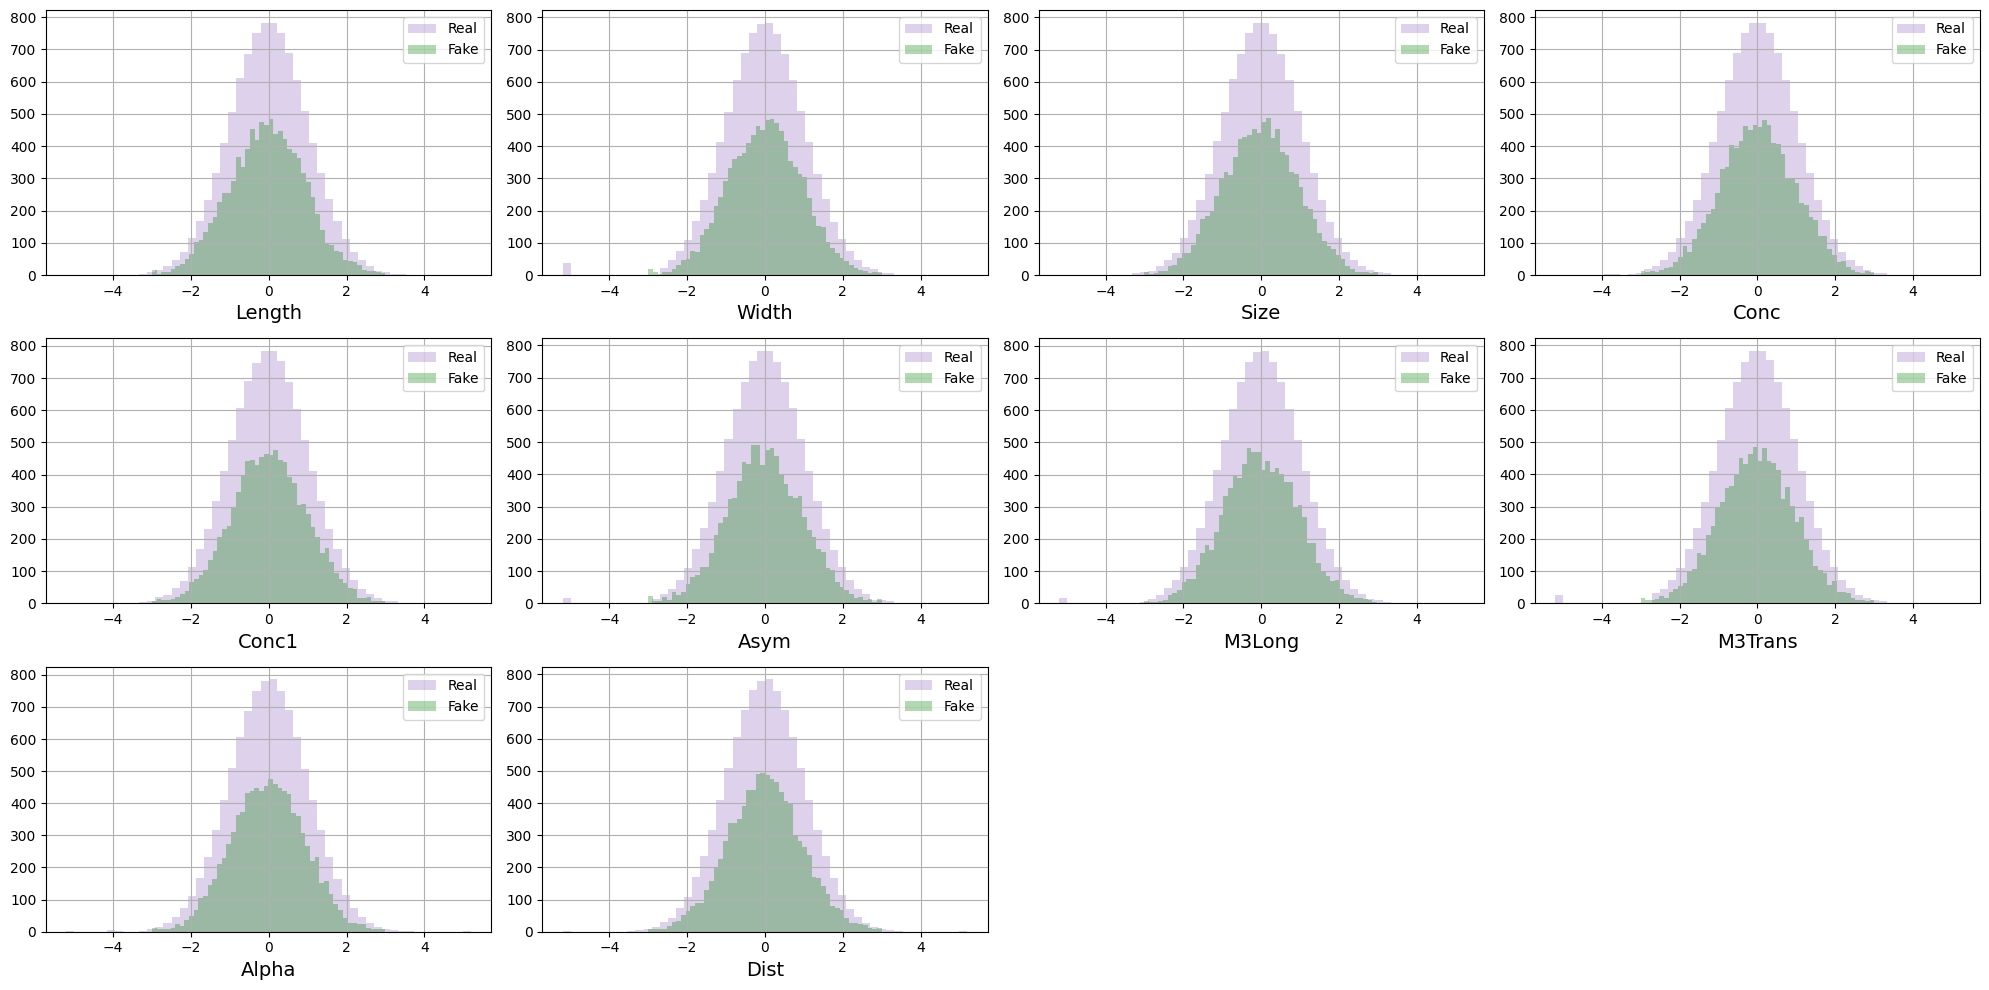

In [362]:
# plot_hists(qt_train.inverse_transform(X_train), qt_train.inverse_transform(X_fake_train), names, label1="Real", label2="Fake", bins=50)
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [363]:
X_fake_test = generate_with_diffusion(model, y_test, X_test.shape, noise_scheduler).cpu()

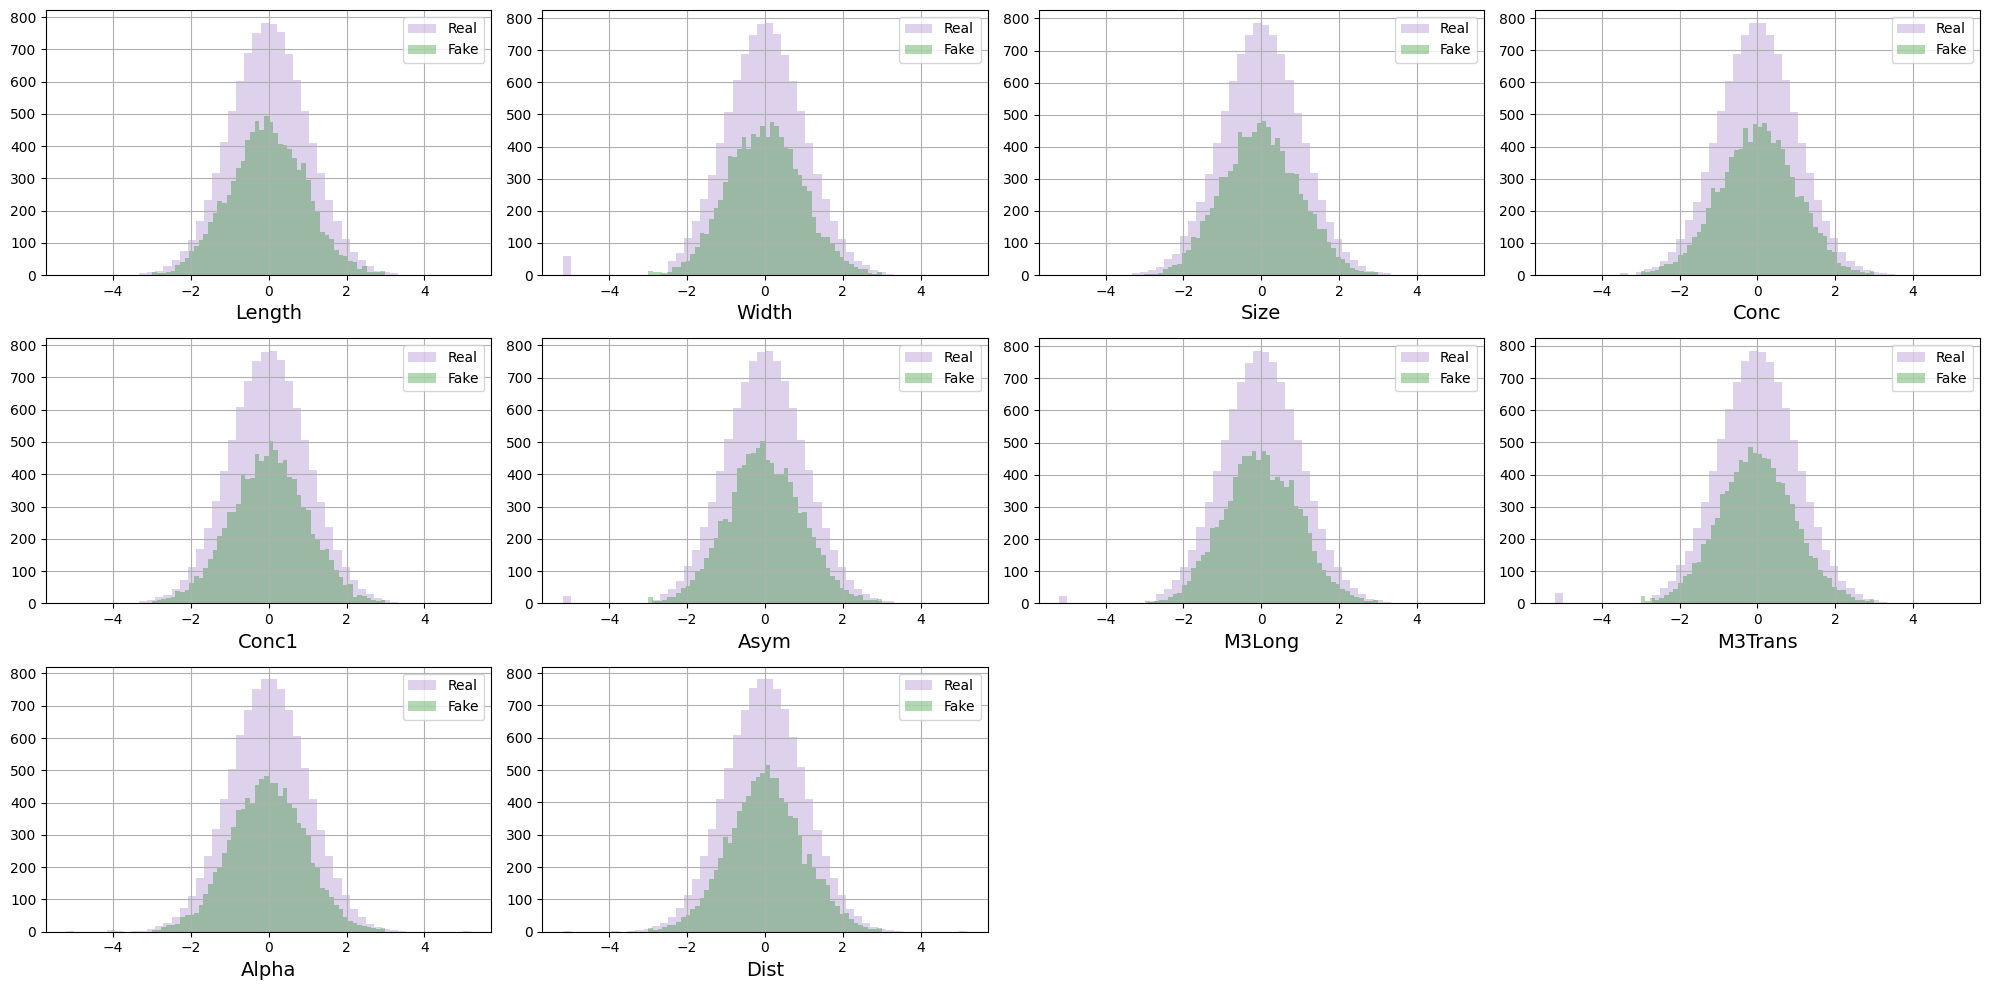

In [364]:
# plot_hists(qt_test.inverse_transform(X_test), qt_test.inverse_transform(X_fake_test), names, label1="Real", label2="Fake", bins=50)
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [365]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [366]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(qt_train.inverse_transform(XX_train), yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(qt_test.inverse_transform(XX_test))[:, 1]

In [367]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.5702132018872159


In [368]:
# torch.save(model.state_dict, 'best_diff_057.pt')

### Комментарий

В итоге ROC AUC на бустинге получился 0.57, по сравнению с GAN это крутой результат. Классификатор я тренировал на изначальных распределениях, мне показалось это более правильным.

# Потоки (4 балла)

## Задание 8 (1.5 балла)

Диффузия показала себя как достойный конкурент GAN модели. Так как данных не много, обучали не долго, задача не сложная - отличия от GAN не так заметны, но все равно достойные.

Для Diffusion получили ROC AUC около 0.73 (меньше лучше). Попробуем обучить RealNVP для решения этой задачи.

**Дополните базовый класс для нормализационного необходимым.**

<center><img src="img/mem1.jpg" width="500"></center>

<center><img src="img/mem2.jpg" width="500"></center>

In [38]:
trainloader = torch.utils.data.DataLoader(X_train, batch_size=64, shuffle=True)

In [39]:
class NormalizingFlow(nn.Module):

    def __init__(self, layers, prior):
        super(NormalizingFlow, self).__init__()

        # your code below
        self.layers = nn.ModuleList(layers)
        self.prior = prior

    def log_prob(self, x):
        log_likelihood = None

        for layer in self.layers:
            x, change = layer.f(x)
            if log_likelihood is not None:
                log_likelihood = log_likelihood + change
            else:
                log_likelihood = change

        log_likelihood = log_likelihood + self.prior.log_prob(x)

        return log_likelihood.mean()

    def sample(self, num_samples):
        x = self.prior.sample((num_samples, ))

        for layer in self.layers[::-1]:
            x = layer.g(x)

        return x

## Задание 9 (2 балла)

Реализуйте нейронную сеть RealNVP. Возьмите для прямого и обратного преобразования нейронную сеть (функцию) со следующими параметрами:

- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

In [40]:
import torch.nn as nn

class RealNVP(nn.Module):
    def __init__(self, var_size, mask, hidden=100):
        super(RealNVP, self).__init__()
        self.mask = mask  # вам это может не понадобиться. Восприниматйте как подсказку
        self.var_size = var_size

        self.nn_t = nn.Sequential(
            nn.Linear(in_features=var_size, out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=var_size),
        )
        self.nn_s = nn.Sequential(
            nn.Linear(in_features=var_size, out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=var_size),
        )

    def f(self, x):
        t = self.nn_t(x * self.mask[None, :])
        s = torch.tanh(self.nn_s(x * self.mask[None, :]))

        new_x = (x * torch.exp(s) + t) * (1 - self.mask[None, :]) + x * self.mask[None, :]
        log_det = (s * (1 - self.mask[None, :])).sum(dim=-1)
        return new_x, log_det

    def g(self, x):
        t = self.nn_t(x * self.mask[None, :])
        s = torch.tanh(self.nn_s(x * self.mask[None, :]))

        new_x = ((x - t) * torch.exp(-s)) * (1 - self.mask[None, :]) + x * self.mask[None, :]
        return new_x

In [41]:
def train_nf(tr_dataloader, nf, opt, num_epochs):
    nf.train()
    loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):
        print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:

            x = batch.float()

            opt.zero_grad()

            loss = -nf.log_prob(x)
            loss.backward()

            opt.step()

            loss_trace.append((iter_i, loss.item()))

            iter_i += 1

In [42]:
prior = torch.distributions.MultivariateNormal(torch.zeros(10), torch.eye(10))

layers = []
for i in range(4):
    layers.append(RealNVP(var_size=10, mask=((torch.arange(10) + i) % 2)))

nf = NormalizingFlow(layers=layers,
                    prior=prior)

opt = torch.optim.Adam(nf.parameters(), lr=1e-3)

In [43]:
train_nf(trainloader, nf, opt, num_epochs=10)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


## Задание 10 (0.5 балла)

По аналогии с прошлым экспериментом с диффузией сгенерируйте выборку фейковых объектов, равную размеру тестовой выборки, и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с остальными моделями?

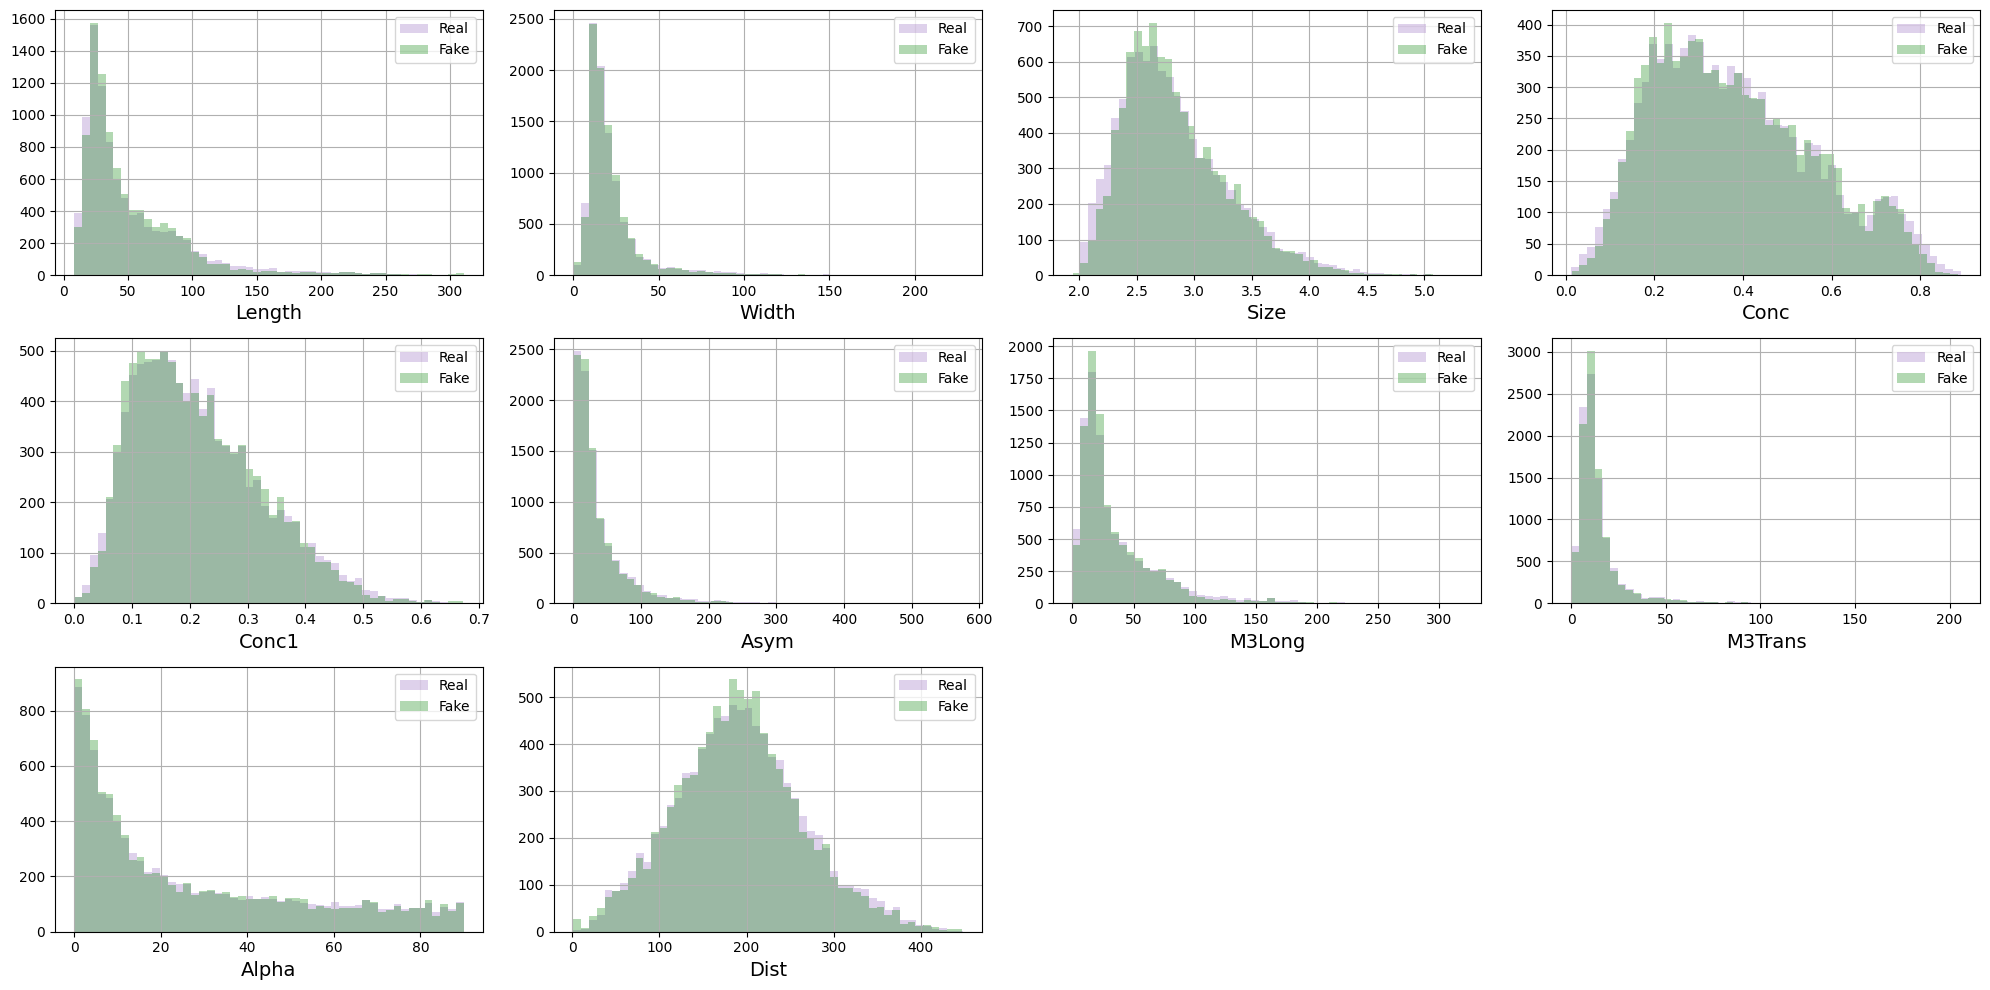

In [44]:
with torch.no_grad():
    X_fake_train = nf.sample(9510).cpu().numpy()
plot_hists(qt_train.inverse_transform(X_train), qt_train.inverse_transform(X_fake_train), names, label1="Real", label2="Fake", bins=50)

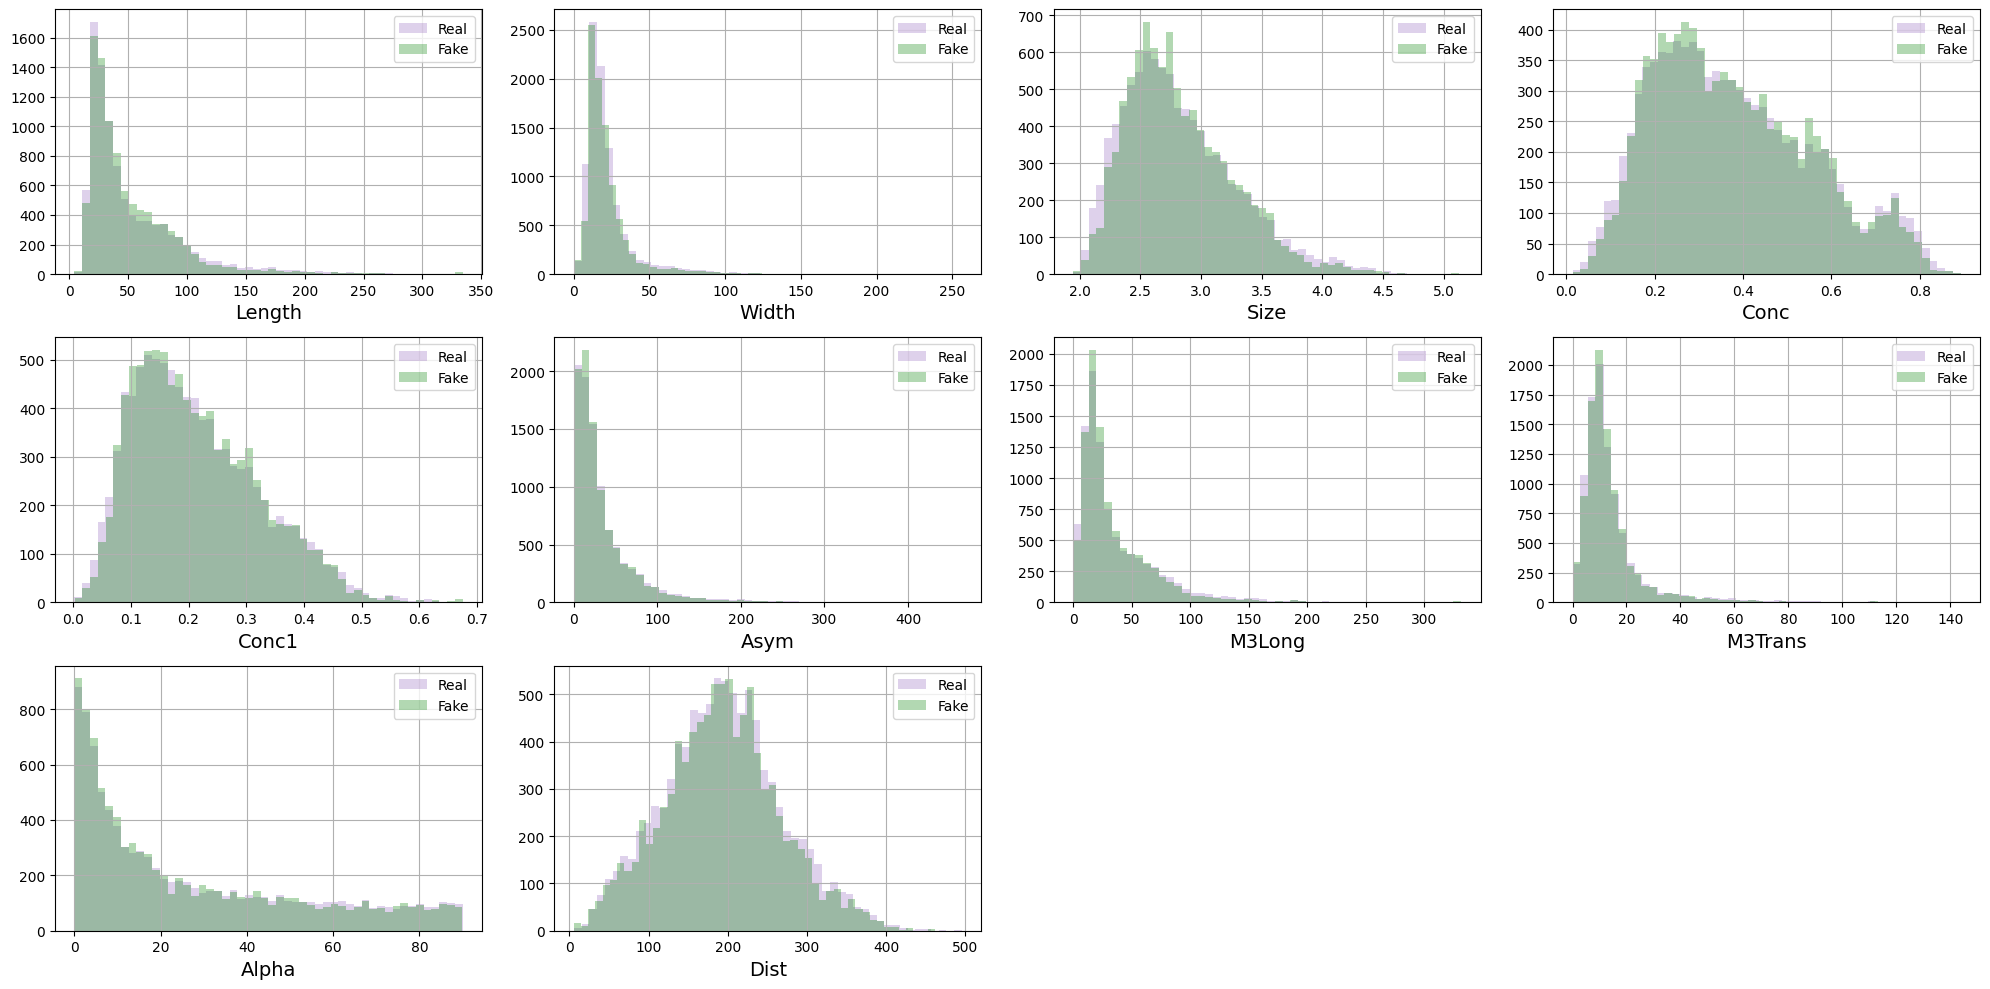

In [45]:
with torch.no_grad():
    X_fake_test = nf.sample(9510).cpu().numpy()
plot_hists(qt_test.inverse_transform(X_test), qt_test.inverse_transform(X_fake_test), names, label1="Real", label2="Fake", bins=50)

In [46]:
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(qt_train.inverse_transform(XX_train), yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(qt_test.inverse_transform(XX_test))[:, 1]

In [48]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6404302405680666


### Комментарий

Результаты получились сходу очень неплохими, гораздо лучше чем в базовой версии у всех других моделей. Бустинг так же учил на изначальных распределениях, разницы нет, просто мне так показалось правильнее.

# Улучшения (1+ балл)

Попробуйте настроить параметры обучения какой-нибудь модели или еще как-нибудь их улучшить, чтобы получить как можно меньший ROC AUC. Что получилось? Какая модель лучше?

Ставим 0.1 балл за каждую сотую скора сверх (сниз) ROC-AUC=0.65 невключительно. Т.е. за 0.65 получаете 0, за 0.649 -- 0.1, 0.639 -- 0.2, 0.609 -- 0.5, 0.559 -- 1

<ins>Лучший скор я выбил **в пункте с диффузионной моделью (~0.570)**. Там же описано, что и как обучал, пожалуйста, посмотрите туда!</ins>

# (*) Аналитика (1 балл)

***Убедительно* подвтердите или опровергните гипотезу "Синтетические данные НЕ помогают лучше классифицировать частицы из исходного датасета."**

Здесь от вас ожидается что-то в духе аналитической записки. Приветствуются графики и прочие "умные вещи". На максимальный балл это весьма объемное задание.